In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../../TMENS_analysis/')) # use the same src as TMENS_analysis
if module_path not in sys.path:
    sys.path.append(module_path)
os.getcwd()

'/scratch/ziqi.kang/NIPMAP_updated/macro_micro_niches/ISS_analysis/notebooks'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import json
import qpsolvers
import warnings
import random
warnings.filterwarnings('ignore')

from matplotlib.legend import Legend
from skimage import io
from pathlib import Path
from sklearn.decomposition import PCA
from src.utils.archetypes import ArchetypalAnalysis
from src.CellAbundance import CellAbundance, generate_abundance_matrix, join_abundance_matrices
from src.utils.visualization import radius_pc_heatmap, plot_cells_positions, plot_cev_radius, plot_stacked_var_radius, radius_pc_all_variance, radius_pc_variance_contourf, plot_cells_markers_tmens
from src.utils.visualization import plot_scatter_pca, plot_3Dscatter_pca, archetypes_bar_plot, archetype_simple_plot, plot_cells_positions, plot_all_tumors_cell_positions, get_segmentation_matrix
from src.utils.equations import arch2color, alfa2rgb, scale, color_mapper
from src.utils.equations import compute_cells_niches_weights, get_niches_cell_abund
from functools import partial

## Radius Analysis

In [3]:
ROOT_DATA_PATH = "../data/"

CELL_TYPES = ['secretory', 'epithelial', 'proliferating smooth muscle', 'lymphatic endothelial', 'arterial', 
'mesenchymal', 'ciliated epithelial', 'neuronal', 'pericyte', 'ASM', 
'fibroblast', 'megakaryocyte', 'proximal progenitor', 'endothelial', 'neuroendocrine', 
'chondroblast', 'Dendritic', 'macrophage', 'myeloid', 
'mesothelial', 'monocyte', 'capillary', 'ILC3', 'B-cell', 
'erythrocyte', 'myeloid progenitor', 'mast/basophil', 'venous', 
'neutrophil', 'ILC2', 'lymphoid progenitor', 'natural killer']

full_patient_ids = [1]

N_SITE = 5000
radius = np.linspace(np.log(5), np.log(100), num=15)
radius = np.rint(np.power(np.e, radius).astype(float))
METHOD = 'gaussian'
x_size = 6500
y_size = 6500

expl_var_ratio_gauss = {}
for r in radius:
    print(r)
    gaussian_count_list = generate_abundance_matrix(CELL_TYPES, full_patient_ids, N_SITE, r, method=METHOD, snr=3, root=ROOT_DATA_PATH, image_x_size=x_size, image_y_size=y_size)
    sites, patient_ids,s_ids, _ = join_abundance_matrices(gaussian_count_list)
    pca = PCA()
    pc = pca.fit_transform(sites)
    expl_var_ratio_gauss[r] = np.cumsum(pca.explained_variance_ratio_)

5.0
6.0
8.0
10.0
12.0
15.0
18.0
22.0
28.0
34.0
42.0
53.0
65.0
81.0
100.0


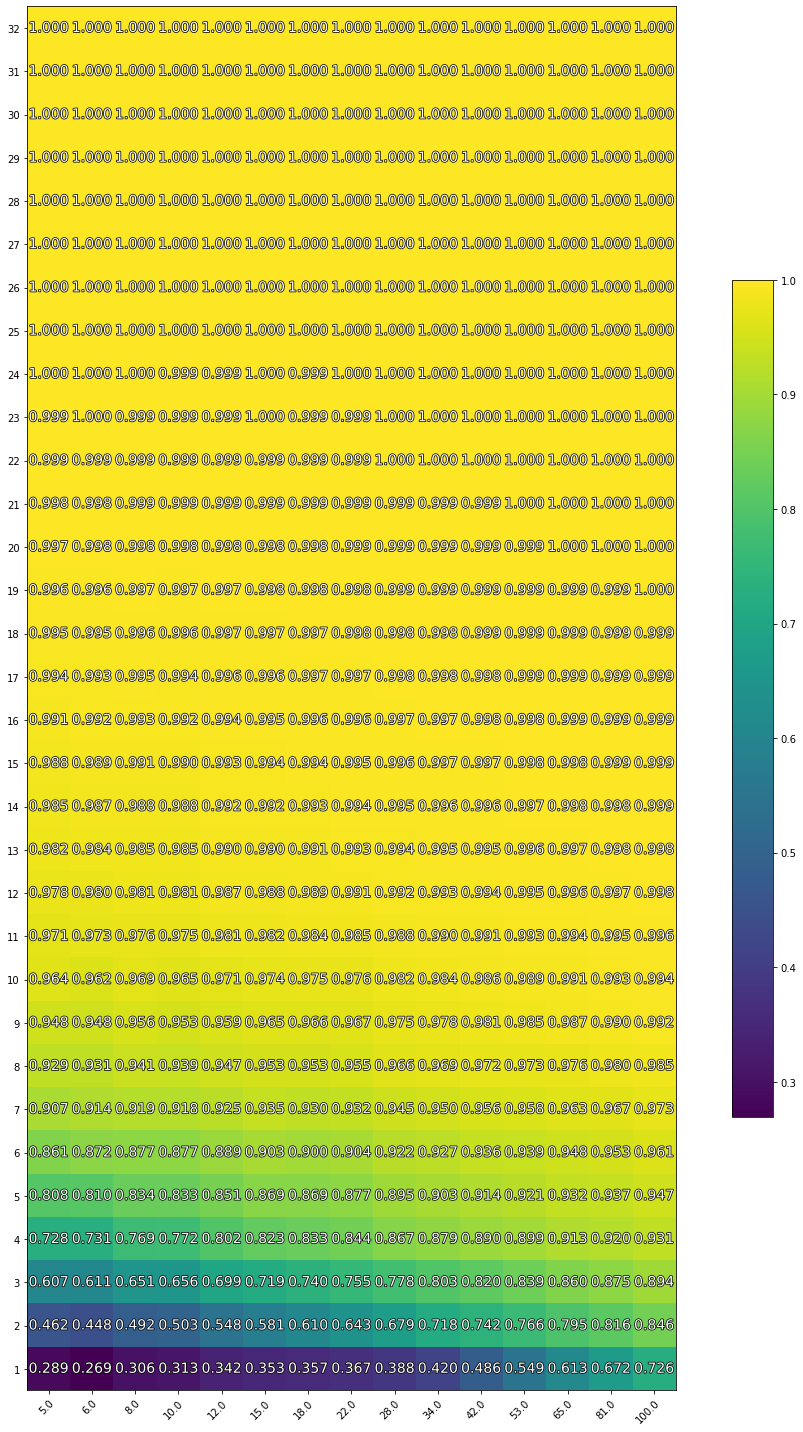

In [4]:
radius_pc_heatmap(expl_var_ratio_gauss)

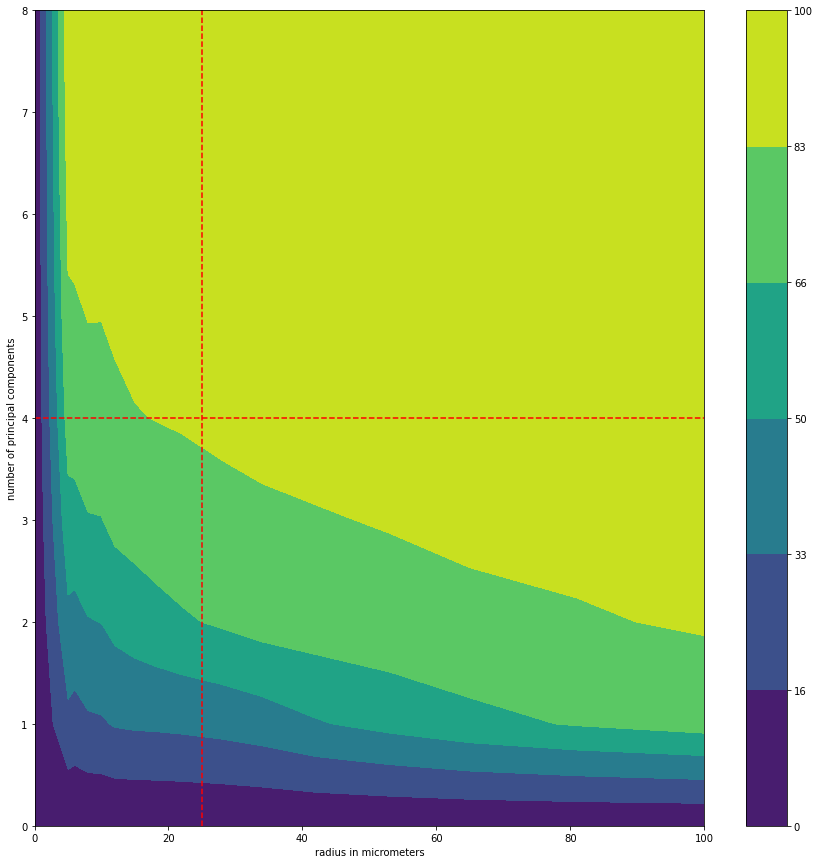

In [5]:
radius_pc_all_variance(expl_var_ratio_gauss,radius_lim=25,nPC_lim=4,cells_number=33, 
                       save_fig=True, path_fig="../output/radius_plot.svg")

## Archetypal Analysis

Input all parameters needed for the analysis. 

In [6]:
ROOT_DATA_PATH = "../data/"

CELL_TYPES = ['secretory', 'epithelial', 'proliferating smooth muscle', 'lymphatic endothelial', 'arterial', 
'mesenchymal', 'ciliated epithelial', 'neuronal', 'pericyte', 'ASM', 
'fibroblast', 'megakaryocyte', 'proximal progenitor', 'endothelial', 'neuroendocrine', 
'chondroblast', 'Dendritic', 'macrophage', 'myeloid', 
'mesothelial', 'monocyte', 'capillary', 'ILC3', 'B-cell', 
'erythrocyte', 'myeloid progenitor', 'mast/basophil', 'venous', 
'neutrophil', 'ILC2', 'lymphoid progenitor', 'natural killer']

patient_id = [1]

N_SITE = 20000 
NBNICHES = 5
RADIUS = 25
METHOD = "gaussian"
x_size = 6500
y_size = 6500

color_range = [[255, 0, 223],
 [0, 0, 255],
 [70, 203, 236],
 [255, 0, 0],
 [0, 153, 51],
 [225, 255, 0],
 [0, 0, 0]]
 
color_list = color_range[0:NBNICHES-1]
color_list.append([0,0,0])

SAVE_DATA_PATH = Path("{}/niche{}_radius{}_patientid{}/".format(ROOT_DATA_PATH,NBNICHES,RADIUS,patient_id))
SAVE_DATA_PATH.mkdir(parents=True, exist_ok=True)

Generate cell abundance matrix based on sites. Fit archetype and visualize it. 

0.78% Total Exp. Var.


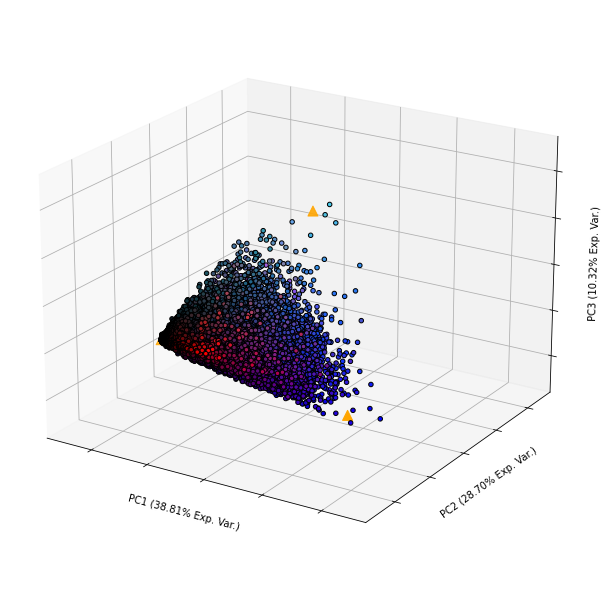

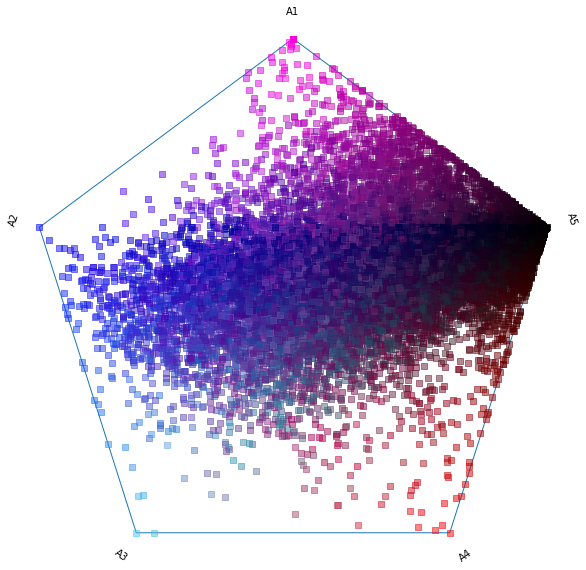

In [7]:
CellAb_list = generate_abundance_matrix(CELL_TYPES, patient_id, N_SITE, RADIUS, method=METHOD, snr=3, image_x_size = x_size, image_y_size = y_size, center_sites_cells=False, root=ROOT_DATA_PATH, random_seed=1022)
sites, patients_ids, sites_ids, _ = join_abundance_matrices(CellAb_list)

CellAb_df = pd.DataFrame() 
for ca in CellAb_list:
    abundance_df = pd.DataFrame(ca.abundance_matrix,columns = CELL_TYPES)
    abundance_df['site_id'] = np.arange(len(abundance_df))
    abundance_df['patient_id'] = ca.patient_id
    CellAb_df = CellAb_df.append(abundance_df)
CellAb_df = CellAb_df.reset_index()

pca_obj = PCA()
pc_proj = pca_obj.fit_transform(sites)


AA = ArchetypalAnalysis(n_archetypes = NBNICHES, 
    tolerance = 0.001, 
    max_iter = 200, 
    random_state = 0, 
    C = 0.0001, 
    initialize = 'random', 
    redundancy_try = 30)

AA.fit_transform(pc_proj[:,:NBNICHES-1])


def round2one(v):
    return v if v <= 1.0 else 1.0
color_map = np.array(color_list).T
sites_archetype = [np.array([round2one(x) for x in color_mapper(color_map, c)/255]) for c in AA.alfa.T]
p = np.array(sites_archetype)
p[p > 1]

plot_3Dscatter_pca(pc_proj, pca_obj.explained_variance_ratio_, labels=sites_archetype, archetypes=AA.archetypes)

un, counts = np.unique(np.argmax(AA.alfa.T, axis=1), return_counts=True)
bb_counts = dict(zip(un+1, (counts/N_SITE)*100))
bb_counts

AA.plot_simplex(AA.alfa, plot_args={'c': sites_archetype})

## Visualization

### Niche cellular density barplot

Plot the cell density barplot for all niches, in order to explore biological meanings. 

In [8]:
n_comp = NBNICHES-1
res = np.dot(AA.archetypes.T, pca_obj.components_[:n_comp,:])+np.mean(sites, axis=0)

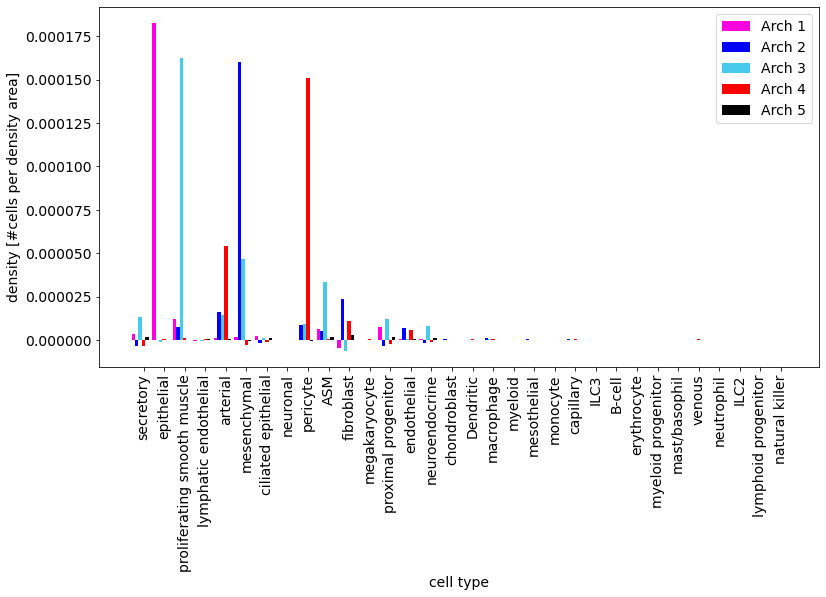

In [9]:
archetype_colors = np.array(color_list)/255
archetypes_bar_plot(res, CELL_TYPES, archetype_colors, y_axis='density', radius=RADIUS, path_fig="{}/arche_barplot.svg".format(SAVE_DATA_PATH))

In [10]:
# save pca and cell abundance in each niche, for downstream analysis. 

pcres = AA.archetypes.T
niche_pcabundance = pd.DataFrame(pcres)
niche_pcabundance.to_csv("{}/niche_pcabundance.csv".format(SAVE_DATA_PATH))
niche_cellabundance = pd.DataFrame(res, columns=CELL_TYPES)
niche_cellabundance.to_csv("{}/niche_cellbundance.csv".format(SAVE_DATA_PATH))

### Original tissue and segmented tissue

Plot the original tissue and the tissue segmented according to the nices. 

4


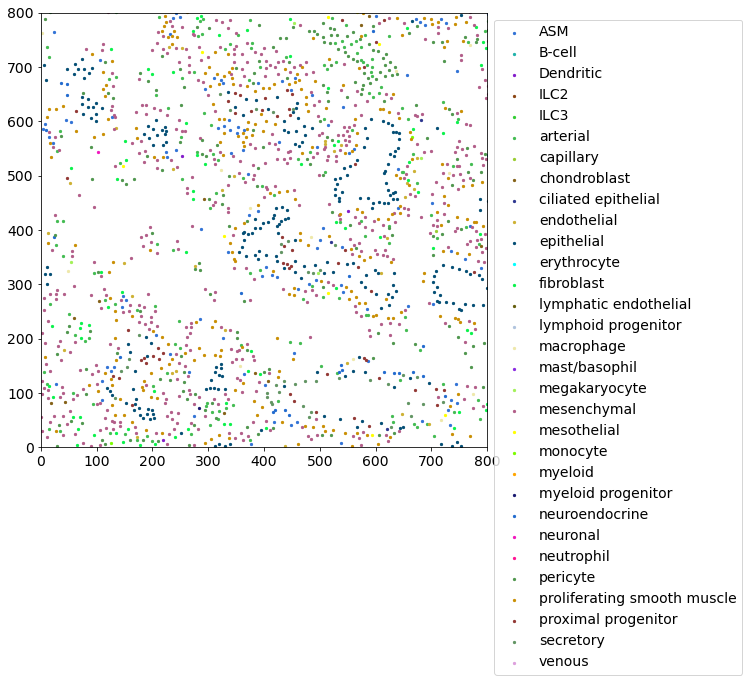

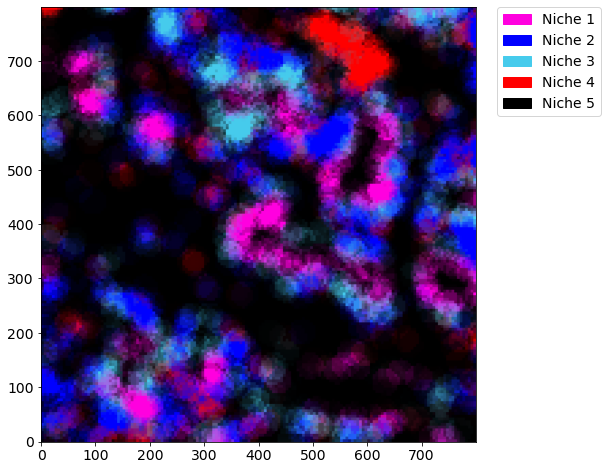

In [11]:
h = 800
w = 800
GRANULARITY = 5 # controls the resolution of niche segmentation. 
cell_data = pd.read_csv("{}/patient{}_cell_positions.csv".format(ROOT_DATA_PATH, 1))

colors = ['#629563', '#044E75', '#CA8F04', '#645D0D','#43BC52', 
'#B25E89', '#2E3790', '#F118BE','#50974E', '#3273D6', 
'#0AF24B', '#A3F159','#933835', '#CEB134', '#226BCF', 
'#856218','#831CCB','#EEE8AA', '#FFA500', '#FFFF00', 
'#7CFC00', '#9ACD32', '#32CD32', '#20B2AA','#00FFFF',
'#191970', '#8A2BE2','#DDA0DD','#FF1493','#8B4513',
'#B0C4DE','#CD853F','#9400D3','#0000FF'] # specify the colors for original figure, because too many cell types

plot_cells_positions(cell_data, CELL_TYPES, segment_image=False, counting_type='gaussian',
                            segmentation_type='smooth', color_vector = colors, h=h, w=w, granularity=GRANULARITY, radius=RADIUS,
                            pca_obj=pca_obj, AA_obj=AA, to_plot = 'all', path_fig="{}/Origin_fig_size{}*{}.svg".format(SAVE_DATA_PATH,h,w))

plot_cells_positions(cell_data, CELL_TYPES, segment_image=True, counting_type='gaussian',
                            segmentation_type='smooth', color_vector = color_list, h=h, w=w, granularity=GRANULARITY, radius=RADIUS,
                            pca_obj=pca_obj, AA_obj=AA, to_plot = 'None', path_fig="{}/Niche_segment_size{}*{}.svg".format(SAVE_DATA_PATH,h,w))

### Plot interested markers in the segmented tissue

True
4


No handles with labels found to put in legend.


(120, 6)
ok


<module 'matplotlib.pyplot' from '/scratch/anissa.el/miniconda3/envs/building-blocks/lib/python3.7/site-packages/matplotlib/pyplot.py'>

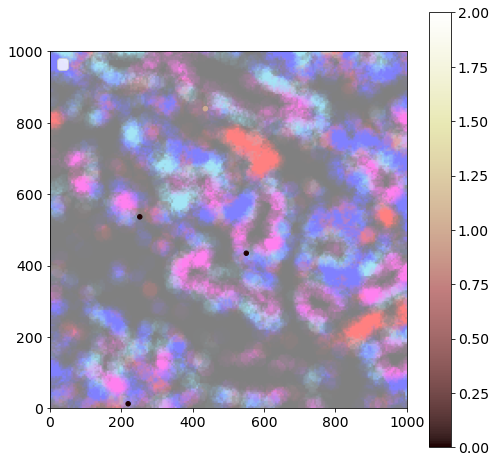

In [23]:
patientID = 1
GRANULARITY = 5
CELLT="Dendritic"
Marker = "FZD1"
symb = []

plot_cells_markers_tmens(patient_id=patientID,cell_types=CELL_TYPES,path_data=ROOT_DATA_PATH,
                         data_markers_path="{}/cellData_{}.csv".format(ROOT_DATA_PATH, patientID),
                         cell_type=CELLT, marker=Marker, symbols=symb,
                         segment_image = True, segmentation_type="smooth",
                         counting_type = "gaussian", color_vector = color_list, 
                         h = 1000,w = 1000, granularity=GRANULARITY, radius = 25,
                         pca_obj = pca_obj,AA_obj = AA,
                         to_plot=[], path_fig = "../output/patient"+str(patientID)+"_tmens_"+CELLT+"_"+Marker+".svg",
                        intOutQuant=0.01)

True
4


No handles with labels found to put in legend.


(8064, 6)
ok
True
4


No handles with labels found to put in legend.


(8064, 6)
ok


<module 'matplotlib.pyplot' from '/scratch/anissa.el/miniconda3/envs/building-blocks/lib/python3.7/site-packages/matplotlib/pyplot.py'>

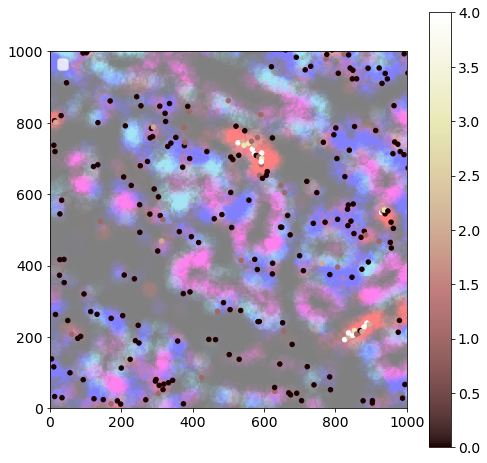

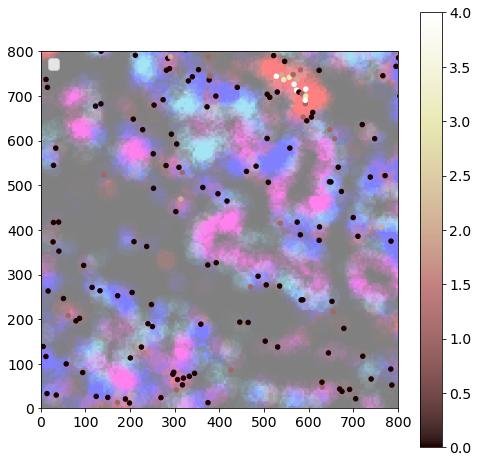

In [25]:
patientID = 1
GRANULARITY = 5
CELLT="arterial"
Marker = "JAG1"
symb = []

plot_cells_markers_tmens(patient_id=patientID,cell_types=CELL_TYPES,path_data=ROOT_DATA_PATH,
                         data_markers_path="{}/cellData_{}.csv".format(ROOT_DATA_PATH, patientID),
                         cell_type=CELLT, marker=Marker, symbols=symb,
                         segment_image = True, segmentation_type="smooth",
                         counting_type = "gaussian", color_vector = color_list, 
                         h = 1000,w = 1000, granularity=GRANULARITY,radius = 25,
                         pca_obj = pca_obj,AA_obj = AA,
                         to_plot=[], path_fig = "../output/patient"+str(patientID)+"_tmens_"+CELLT+"_"+Marker+".svg",
                        intOutQuant=0.01)
# Visualize in 800 x 800 um image
plot_cells_markers_tmens(patient_id=patientID,cell_types=CELL_TYPES,path_data=ROOT_DATA_PATH,
                         data_markers_path="{}/cellData_{}.csv".format(ROOT_DATA_PATH, patientID),
                         cell_type=CELLT, marker=Marker, symbols=symb,
                         segment_image = True, segmentation_type="smooth",
                         counting_type = "gaussian", color_vector = color_list, 
                         h = 800,w = 800, granularity=GRANULARITY,radius = 25,
                         pca_obj = pca_obj,AA_obj = AA,
                         to_plot=[], path_fig = "../output/patient"+str(patientID)+"_tmens_"+CELLT+"_"+Marker+"_800x800.svg",
                        intOutQuant=0.01)



True
4
(8064, 6)


No handles with labels found to put in legend.


ok


<module 'matplotlib.pyplot' from '/scratch/anissa.el/miniconda3/envs/building-blocks/lib/python3.7/site-packages/matplotlib/pyplot.py'>

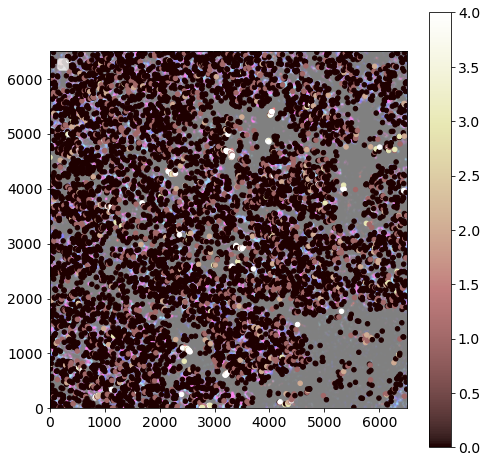

In [42]:
# Visualize the whole image
plot_cells_markers_tmens(patient_id=patientID,cell_types=CELL_TYPES,path_data=ROOT_DATA_PATH,
                         data_markers_path="{}/cellData_{}.csv".format(ROOT_DATA_PATH, patientID),
                         cell_type=CELLT, marker=Marker, symbols=symb,
                         segment_image = True, segmentation_type="smooth",
                         counting_type = "gaussian", color_vector = color_list, 
                         h = 6500,w = 6500, granularity=GRANULARITY,radius = 25,
                         pca_obj = pca_obj,AA_obj = AA,
                         to_plot=[], path_fig = "../output/patient"+str(patientID)+"_tmens_"+CELLT+"_"+Marker+"_wholeImage.svg",
                        intOutQuant=0.01)

In [ ]:
patientID = 1
GRANULARITY = 5
CELLT="Dendritic"
Marker = "FZD1"
symb = []
#TODO generate 6500 x 6500 image of FZD1+ Dendritic mapped on niches; WARNING: time-consuming operation !!!
plot_cells_markers_tmens(patient_id=patientID,cell_types=CELL_TYPES,path_data=ROOT_DATA_PATH,
                         data_markers_path="{}/cellData_{}.csv".format(ROOT_DATA_PATH, patientID),
                         cell_type=CELLT, marker=Marker, symbols=symb,
                         segment_image = True, segmentation_type="smooth",
                         counting_type = "gaussian", color_vector = color_list, 
                         h = 800,w = 800, granularity=GRANULARITY,radius = 25,
                         pca_obj = pca_obj,AA_obj = AA,
                         to_plot=[], path_fig = "../output/patient"+str(patientID)+"_tmens_"+CELLT+"_"+Marker+"_800x800.svg",
                        intOutQuant=0.01)

# Visualize the whole image
plot_cells_markers_tmens(patient_id=patientID,cell_types=CELL_TYPES,path_data=ROOT_DATA_PATH,
                         data_markers_path="{}/cellData_{}.csv".format(ROOT_DATA_PATH, patientID),
                         cell_type=CELLT, marker=Marker, symbols=symb,
                         segment_image = True, segmentation_type="smooth",
                         counting_type = "gaussian", color_vector = color_list, 
                         h = 6500,w = 6500, granularity=GRANULARITY,radius = 25,
                         pca_obj = pca_obj,AA_obj = AA,
                         to_plot=[], path_fig = "../output/patient"+str(patientID)+"_tmens_"+CELLT+"_"+Marker+"_wholeImage.svg",
                        intOutQuant=0.01)

## Save data

In [9]:
# save the archetypal analysis result

dict_pca = {"PC_proj":pc_proj.tolist(),"components":pca_obj.components_.tolist(),"expl_variance":pca_obj.explained_variance_.tolist(), "expl_var_ratio":pca_obj.explained_variance_ratio_.tolist(),"mean":pca_obj.mean_.tolist()}
dict_AA = {"archs_coord": AA.archetypes.T.tolist(), "alfas": AA.alfa.tolist()}
PCA_json = json.dumps(dict_pca, indent=4)
AA_json = json.dumps(dict_AA, indent=4)

with open("{}/pca_sites.json".format(SAVE_DATA_PATH), "w") as outfile:
    outfile.write(PCA_json)
        
with open("{}/AA_sites.json".format(SAVE_DATA_PATH),"w") as outfile2:
    outfile2.write(AA_json)

In [10]:
# generate sites centered on cells and save
# take ~10 mins

CellAbCC_list = generate_abundance_matrix(CELL_TYPES, patient_id, N_SITE, RADIUS, method=METHOD, snr=3, image_x_size = 800, image_y_size = 800, center_sites_cells=True, root=ROOT_DATA_PATH, random_seed=1022)
sitesCC, patients_ids2, sites_ids2, _ = join_abundance_matrices(CellAbCC_list, center_sites_cells=True)#
NichesProf = get_niches_cell_abund(sitesCellAb=sites, pcaSites=pca_obj, ArchObj=AA, nComp=NBNICHES-1)
sites_alfa = compute_cells_niches_weights(niches=NichesProf,cellsSites=sitesCC,nbNiches=NBNICHES)


In [11]:
sites_archs = pd.DataFrame(sites_alfa)
sites_archs['patient_id'] = patients_ids2
sites_archs["site_id"] = sites_ids2.iloc[:,0]
sites_archs["cell_type_site"] = sites_ids2.iloc[:,1]
sites_archs["TOT_cell_dens"]= sitesCC.sum(axis=1)

In [12]:
CellAbCC_df = pd.DataFrame(columns=[])
for ca in CellAbCC_list:
    df_ca = ca.get_site_cell_id_df()
    df_ca['patient_id'] = np.repeat(int(ca.patient_id), df_ca.shape[0], axis=0)
    # CellAbCC_df = pd.concat([CellAbCC_df, df_ca], axis=1)
    CellAbCC_df = CellAbCC_df.append(df_ca)
CellAbCC_df = CellAbCC_df.reset_index(drop = True)

In [13]:
# save the result 

dict_caSites = {"cellAbSites": CellAb_df.to_dict()}
dict_caSitesCC = {"cells_niches": sites_archs.to_dict(),"cellAb_sitesCC": CellAbCC_df.to_dict()}

caSites_json = json.dumps(dict_caSites,indent=4)
cellsNiches_json = json.dumps(dict_caSitesCC,indent=4)

with open("{}/ca_sites.json".format(SAVE_DATA_PATH),"w") as outfile3:
    outfile3.write(caSites_json)      
with open("{}/cells_niches.json".format(SAVE_DATA_PATH),"w") as outfile4:
    outfile4.write(cellsNiches_json)

In [15]:
## Generate sites centered on cells in image reduced to 800 x 800 micrometers
# save data into json file (named xs for small image)
CellAbCC_list_xs = generate_abundance_matrix(CELL_TYPES, patient_id, N_SITE, RADIUS, method=METHOD, snr=3, 
                                          image_x_size = 800, image_y_size = 800, center_sites_cells=True, 
                                          root=ROOT_DATA_PATH)
sitesCC_xs, patients_ids2_xs, sites_ids2_xs, _ = join_abundance_matrices(CellAbCC_list_xs, center_sites_cells=True)#
NichesProf = get_niches_cell_abund(sitesCellAb=sites, pcaSites=pca_obj, ArchObj=AA, nComp=NBNICHES-1)
sites_alfa2 = compute_cells_niches_weights(niches=NichesProf,cellsSites=sitesCC_xs,nbNiches=NBNICHES)
sites_archs2 = pd.DataFrame(sites_alfa2)
sites_archs2['patient_id'] = patients_ids2_xs
sites_archs2["site_id"] = sites_ids2_xs.iloc[:,0]
sites_archs2["cell_type_site"] = sites_ids2_xs.iloc[:,1]
sites_archs2["TOT_cell_dens"]= sitesCC_xs.sum(axis=1)

dict_caSitesCC = {"cells_niches": sites_archs2.to_dict()}
cellsNiches_json = json.dumps(dict_caSitesCC,indent=4)
     
with open("{}/cells_niches_xs.json".format(SAVE_DATA_PATH),"w") as outfile4:
    outfile4.write(cellsNiches_json)
